In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import pygame


class SnakeEnv(gym.Env):
    def __init__(self, config=None,render=False):
        super(SnakeEnv, self).__init__()

        self.grid_size = 10
        self.observation_space = spaces.Dict({
            'food':spaces.Box(low=0, high=self.grid_size, shape=(2,), dtype=np.uint8)),
            'snake':spaces.Sequence(spaces.Box(low=0, high=self.grid_size, shape=(2,), dtype=np.uint8)
        })
        self.action_space = spaces.Discrete(4)  # 0: up, 1: down, 2: left, 3: right

        self.snake = [(10, 10)]
        self.food = self._spawn_food()
        self.direction = 3  # Initial direction (0: up, 1: down, 2: left, 3: right)
        self.current_steps = 0

        if render:
            # Pygame initialization
            self.window_size = 300
            self.scale_factor = self.window_size // self.grid_size
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
            pygame.display.set_caption("Snake Game")

    def seed(self, seed=None):
        self.np_random, seed = gym.utils.seeding.np_random(seed)
        return [seed]

    def reset(self, *, seed=None, options=None):
        self.current_steps = 0
        self.snake = [(4, 4)]
        self.food = self._spawn_food()
        self.direction = 3
        return self._get_observation(),{}

    def _spawn_food(self):
        while True:
            food = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if food not in self.snake:
                return food

    def _valid_coords(self, coords):
        return 0 <= coords[0] < self.grid_size and 0 <= coords[1] < self.grid_size

    def _get_observation(self):
        observation = {
            'food':np.array(self.food),
            'snake':np.array(self.snake)
        }
        return observation

    def step(self, action):
        self.current_steps += 1
        self.direction = action

        # Update snake's head based on the direction
        if self.direction == 0:  # Up
            new_head = (self.snake[0][0] - 1, self.snake[0][1])
        elif self.direction == 1:  # Down
            new_head = (self.snake[0][0] + 1, self.snake[0][1])
        elif self.direction == 2:  # Left
            new_head = (self.snake[0][0], self.snake[0][1] - 1)
        else:  # Right
            new_head = (self.snake[0][0], self.snake[0][1] + 1)

        self.snake.insert(0, new_head)

        reward = 0
        if self.snake[0] == self.food:
            self.food = self._spawn_food()
            reward+=1
        else:
            self.snake.pop()

        # Check for collisions
        game_over = self.current_steps > 500
        if (new_head in self.snake[1:] or not self._valid_coords(new_head)):
            reward = -1
            game_over = True
        elif len(self.snake)==self.grid_size*self.grid_size:
            reward = 100
            game_over = True

        return self._get_observation(), reward, game_over, False, {}

    def render(self, mode='human'):
        pygame.event.get()
        self.window.fill((0, 0, 0))

        for segment in self.snake:
            if self._valid_coords(segment):
                pygame.draw.rect(self.window, (0, 255, 0),
                                (segment[1] * self.scale_factor, segment[0] * self.scale_factor,
                                self.scale_factor, self.scale_factor))

        pygame.draw.rect(self.window, (255, 0, 0),
                         (self.food[1] * self.scale_factor, self.food[0] * self.scale_factor,
                          self.scale_factor, self.scale_factor))

        pygame.display.flip()

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' on line 13 (2367385570.py, line 14)

In [32]:
from ray.tune.registry import register_env
register_env("snake", SnakeEnv)

In [33]:
import ray
from ray import tune,air
from ray.rllib.algorithms.algorithm_config import AlgorithmConfig
from ray.rllib.algorithms.callbacks import MemoryTrackingCallbacks
from ray.tune.logger import LoggerCallback
from ray.air import session


class RewardLoggerCallback(LoggerCallback):
    def __init__(self) -> None:
        self.results = []

    def log_trial_result(self, iteration: int, trial, result):
        reward = result  # assuming 'reward' is your reward key
        self.results.append(reward)

callback = RewardLoggerCallback()

stopping_criterion = {"training_iteration": 100}

In [34]:
context = ray.init(ignore_reinit_error=True)

2023-10-16 19:29:27,607	INFO worker.py:1642 -- Started a local Ray instance.


In [35]:
tuner = tune.Tuner(
    "DQN",
    param_space={
        "env": "snake",
        "framework": "torch",
        "num_gpus": 0,
        "num_workers":20,
        "should_checkpoint": True,
    },
    run_config=air.RunConfig(
        stop=stopping_criterion,callbacks=[callback],
        checkpoint_config=air.CheckpointConfig(checkpoint_frequency=1,checkpoint_at_end=True),
        ),
)
results = tuner.fit()
ray.shutdown()

(pid=47664) DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
(pid=47664) 2023-10-16 19:29:34,570	WARNING deprecation.py:50 -- DeprecationWarning: `build_tf_policy` has been deprecated. This will raise an error in the future!
(pid=47664) 2023-10-16 19:29:34,574	WARNING deprecation.py:50 -- DeprecationWarning: `build_policy_class` has been deprecated. This will raise an error in the future!
(DQN pid=47664) 2023-10-16 19:29:34,580	WARNING deprecation.py:50 -- DeprecationWarning: `rllib/algorithms/simple_q/` has been deprecated. Use `rllib_contrib/simple_q/` instead. This will raise an error in the future!
(DQN pid=47664) 2023-10-16 19:29:34,581	WARNING algorithm_config.py:672 -- Cannot create DQNConfig from given `config_dict`! Property should_checkpoint not supported.
(pid=42296) DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!
(pid=39992) DeprecationWarning: `DirectStepOptimizer` 

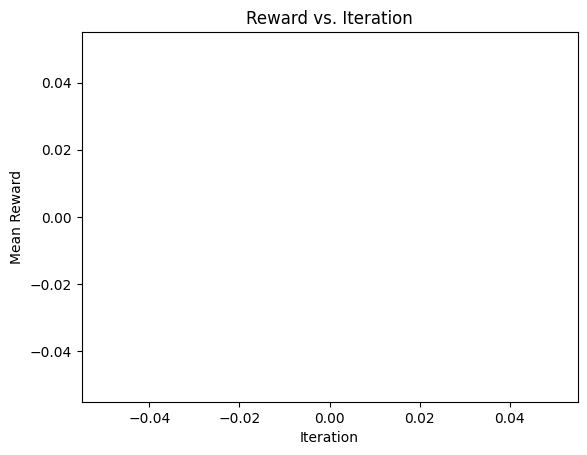

In [6]:
import matplotlib.pyplot as plt

rewards=[i["episode_reward_mean"] for i in callback.results]

plt.plot(rewards)
plt.xlabel("Iteration")
plt.ylabel("Mean Reward")
plt.title("Reward vs. Iteration")
plt.show()

In [7]:
best_result

NameError: name 'best_result' is not defined

In [ ]:
# Get the best result
best_result=results.get_best_result()

# Get the best checkpoint
best_checkpoint=best_result.checkpoint

In [ ]:
from ray.rllib.algorithms.algorithm import Algorithm

register_env("snake",SnakeEnv)
algo=Algorithm.from_checkpoint(best_checkpoint)
# algo=Algorithm.from_checkpoint("C:/Users/micha/ray_results/PPO_2023-10-16_03-09-19/PPO_snake_ed181_00000_0_2023-10-16_03-09-19/checkpoint_000099")

2023-10-16 11:33:33,943	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
2023-10-16 11:33:33,950	WARNING algorithm_config.py:2578 -- Setting `exploration_config={}` because you set `_enable_rl_module_api=True`. When RLModule API are enabled, exploration_config can not be set. If you want to implement custom exploration behaviour, please modify the `forward_exploration` method of the RLModule at hand. On configs that have a default exploration config, this must be done with `config.exploration_config={}`.
c:\Users\micha\miniconda3\envs\rl\lib\site-packages\ray\rllib\algorithms\algorithm.py:484: RayDeprecationWarning: This API is 

In [3]:
from time import sleep

env = SnakeEnv(render=True)
obs = env.reset()[0]
progression=[]
game_over=False

In [27]:
print(env.step(3))
env.render()

({'grid': array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [255,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [

In [ ]:
while not game_over:
	action=algo.compute_single_action(obs)
	obs,reward,game_over,info,ads=env.step(action)
	print(action)
	print(reward)
	env.render()
	sleep(0.2)

2
1
0
1
1
1
0
1
2
1
1
1
3
1
0
1
1
1
0
1
2
1
1
1
3
1
0
1
2
1
1
1
2
1
3
1
1
1
0
1
3
1
3
1
2
1
1
1
2
1
3
1
2
1
1
1
0
1
1
1
0
1
0
1
3
1
0
1
2
1
1
1
3
1
0
1
2
1
1
1
2
1
3
1
3
1
0
1
2
1
1
1
3
1
3
1
2
1
0
1
2
1
1
1
2
1
3
1
3
1
1
1
2
1
3
1
2
1
1
1
0
1
1
1
0
1
0
1
3
1
0
1
0
1
1
1
2
1
1
1
3
1
0
1
2
1
1
1
3
1
3
1
2
1
0
1
1
1
3
1
2
1
0
1
1
1
0
1
1
1
2
1
3
1
0
1
1
1
0
1
1
1
0
1
2
1
1
1
3
1
1
1
0
1
0
1
1
1
0
1
1
1
1
1
0
1
0
1
2
1
1
1
0
1
1
1
3
1
0
1
2
1
1
1
3
1
0
1
1
1
0
1
2
1
1
1
0
1
1
1
0
1
1
1
1
1
0
1
3
1
0
1
2
1
1
1
3
1
0
1
2
1
1
1
3
1
0
1
1
1
0
1
2
1
1
1
1
1
3
1


KeyboardInterrupt: 

In [ ]:
pygame.quit()